# PROJET APPLICATION DE RECOMMANDATION DE FILMS

## PARTIE 1 : KPI

#### **title.akas.tsv.gz** : Ce fichier contient des informations sur les différents titres d’un film ou d’une série TV dans différentes régions et langues.

- **titleId** : Identifiant unique du titre.
- 
- **ordering** : Un nombre pour identifier de manière unique les lignes pour un titleId donné.
- 
- **title** : Le titre localisé.
- 
- **region** : La région pour cette version du titre.
- 
- **language** : La langue du titre.
- 
- **types** : Ensemble énuméré d’attributs pour ce titre alternatif.
- 
- **attributes** : Termes supplémentaires pour décrire ce titre alternatif, non énumérés.
- 
- **isOriginalTitle** : 0 si ce n’est pas le titre original ; 1 si c’est le titre original.
	

#### **title.basics.tsv.gz** : Ce fichier contient des informations de base sur les titres.

- **tconst** : Identifiant unique du titre.
- 
- **titleType** : Le type/format du titre (par exemple, film, court métrage, série TV, épisode TV, vidéo, etc).
- 
- **primaryTitle** : Le titre le plus populaire / le titre utilisé par les réalisateurs sur les supports promotionnels lors de la sortie.
- 
- **originalTitle** : Titre original, dans la langue originale.
- 
- **isAdult** : 0 pour un titre non adulte ; 1 pour un titre adulte.
- 
- **startYear** : Représente l’année de sortie d’un titre. Dans le cas d’une série TV, il s’agit de l’année de début de la série.
- 
- **endYear** : Année de fin de la série TV. ‘\N’ pour tous les autres types de titres.
- 
- **genres** : Comprend jusqu’à trois genres associés au titre.
	
#### **title.crew.tsv.gz** : Ce fichier contient des informations sur l’équipe de tournage d’un titre.

- **tconst** : Identifiant unique du titre.
- 
- **directors** : Réalisateur(s) du titre donné.
- 
- **writers** : Scénariste(s) du titre donné.

#### **title.episode.tsv.gz** : Ce fichier contient des informations sur les épisodes d’une série TV.

- **tconst** : Identifiant de l’épisode.
- 
- **parentTconst** : Identifiant de la série TV parente.
- 
- **seasonNumber** : Numéro de la saison à laquelle appartient l’épisode.
- 
- **episodeNumber** : Numéro de l’épisode dans la série TV.
	
#### **title.principals.tsv.gz** : Ce fichier contient des informations sur les principaux participants d’un titre.

- **tconst** : Identifiant unique du titre.
- 
- **ordering** : Un nombre pour identifier de manière unique les lignes pour un titleId donné.
- 
- **nconst** : Identifiant unique de la personne.
- 
- **category** : La catégorie de travail dans laquelle cette personne était.
- 
- **job** : Le titre spécifique du travail si applicable, sinon ‘\N’.
- 
- **characters** : Le nom du personnage joué si applicable, sinon ‘\N’.

#### **title.ratings.tsv.gz** : Ce fichier contient des informations sur les notes d’un titre.

- **tconst** : Identifiant unique du titre.
- 
- **averageRating** : Moyenne pondérée de toutes les notes des utilisateurs.
- 
- *numVotes** : Nombre de votes que le titre a reçus.

#### **name.basics.tsv.gz** : Ce fichier contient des informations de base sur une personne.

- **nconst** : Identifiant unique de la personne.
- 
- **primaryName** : Nom par lequel la personne est le plus souvent créditée.
- 
- **birthYear** : En format YYYY.
- 
- **deathYear** : En format YYYY si applicable, sinon ‘\N’.
- 
- **primaryProfession** : Les 3 principales professions de la personne.
- 
- **knownForTitles** : Titres pour lesquels la personne est connue.

In [1]:
import os
import io
import gzip
import random
import secrets
import datetime
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
import plotly.io as pio
from sklearn import tree
import plotly.express as px
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from scipy.spatial.distance import pdist, squareform
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from flask import Flask, request, render_template, session, url_for, redirect
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder

#### chargement des datasets de type TSV

In [2]:
# scrapping des noms des fichiers
url = "https://datasets.imdbws.com/"

# contournement d'éventuels protection anti-scrapping
navigator = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"

response = requests.get(url, headers={"User-Agent": navigator})
# response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

# Trouver tous les liens sur la page
liens = soup.find_all("a")

# création de la liste des fichiers
fichiers = []
for lien in liens:
    #  choisir uniquement les liens de type href
    nom_fichier = lien.get("href")
    #  choisir uniquement les liens se terminant par .tsv.gz
    if nom_fichier.endswith(".tsv.gz"):
        # print(nom_fichier)
        fichiers.append(nom_fichier)
print(f"\n fichiers:\n{fichiers} \n")

# Liste des noms de fichiers à télécharger
# fichiers = ['title.principals.tsv.gz',
#             'title.akas.tsv.gz',
#             'name.basics.tsv.gz',
#             'title.basics.tsv.gz',
#             'title.crew.tsv.gz',
#             'title.episode.tsv.gz',
#             'title.ratings.tsv.gz' ]


 fichiers:
['https://datasets.imdbws.com/name.basics.tsv.gz', 'https://datasets.imdbws.com/title.akas.tsv.gz', 'https://datasets.imdbws.com/title.basics.tsv.gz', 'https://datasets.imdbws.com/title.crew.tsv.gz', 'https://datasets.imdbws.com/title.episode.tsv.gz', 'https://datasets.imdbws.com/title.principals.tsv.gz', 'https://datasets.imdbws.com/title.ratings.tsv.gz'] 



In [ ]:
# Création du dictionnaire pour stocker les DataFrames
dfs = {}
liste_noms_df=[]

for fichier in fichiers:
    # url = f'https://datasets.imdbws.com/{fichier}'
    response = requests.get(fichier)
    gzip_file = gzip.open(io.BytesIO(response.content), "rt", encoding="utf-8")
    df = pd.read_csv(gzip_file, sep="\t", low_memory=False)
    # Chaque DataFrame porte le nom du fichier sans l'extension
    nom_sans_extension = os.path.splitext(os.path.basename(fichier))[0]
    # Suppression du tz et remplacement des . par des _
    nom_sans_extension = os.path.splitext(nom_sans_extension)[0].replace(".", "_")
    dfs[nom_sans_extension] = df
    liste_noms_df.append(nom_sans_extension)
    print(f"\nNom du DataFrame : {nom_sans_extension}")

# # séparation des df du dico dfs afin qu'il soient tous séparés
# for nom_df in dfs:
#     df = dfs[nom_df].apply(pd.Series)
#     print(f"\nDataFrame {nom_df} :\n{df.shape}")

In [ ]:
#  séparation des df du dico dfs afin qu'il soient tous séparés
for nom_df in dfs:
    df = dfs[nom_df].apply(pd.Series)
    print(f"\nDataFrame {nom_df} :\n{df.shape}")

## Echantillonnage

##### traitement title_akas

In [ ]:
# par securité on travaille sur un double du df
title_akas2 = title_akas.copy()

- Traitement de la colonne region

In [ ]:
#  Traitement de la colonne region
#  on ne filtre que les films francais
print(f"\n title_akas: {title_akas_fr.shape} ")
liste_region=title_akas['region'].unique().tolist()
print(f"\nliste_region :{liste_region} ")
filtre_fr = title_akas2['region'] == "FR"
title_akas_fr = title_akas2[filtre_fr]
print(f"\n title_akas: {title_akas_fr.shape} ")

- Traitement des colonnes à garder

_Plutot que de supprimer des colonnes il est preferable de garder celles qui nous interessent car  les BDD du site imdb sont mises à jour quotidiennement et peuvent changer de type ou de nom_

In [ ]:
# liste colonnes: ['titleId', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'isOriginalTitle']`
# on garde que les  colonnes suivantes ['titleId', 'title', 'region', 'types']`
title_akas_fr = title_akas_fr[['titleId', 'title', 'region', 'types']]


- Traitement de la colonne types

In [ ]:
types_film=title_akas_fr["types"].unique().tolist()
print(f"\ntypes_film :\n{types_film}")
# surla liste des types ['imdbDisplay',
#  ['imdbDisplay','alternative', '\\N', 'tv', 'video', 'dvd', 'working', 'festival'] on ne garde que  ['imdbDisplay','tv', 'video','festival']
types_to_keep = ['imdbDisplay', 'tv', 'video', 'festival']
filtre_type_film = title_akas_fr['types'].isin(types_to_keep)
title_akas_fr = title_akas_fr[filtre_type_film]

In [64]:
# # remplacement de la colonne index par titleId
title_akas_fr.reset_index(drop=True, inplace=True)
title_akas_fr.set_index("titleId", inplace=True)
title_akas_fr

,title,region,types
titleId,,,
tt0000002,Le clown et ses chiens,FR,imdbDisplay
tt0000003,Pauvre Pierrot,FR,imdbDisplay
tt0000004,Un bon bock,FR,imdbDisplay
tt0000010,La sortie de l'usine Lumière à Lyon,FR,imdbDisplay
tt0000012,L'arrivée d'un train à La Ciotat,FR,imdbDisplay
...,...,...,...
tt9915980,Burning the clutch,FR,imdbDisplay
tt9916162,Making of 'La Virgen de los sicarios',FR,imdbDisplay
tt9916192,Danielle Darrieux: Il est poli d'être gai!,FR,imdbDisplay


#### traitement title_principals

In [67]:
# par securité on travaille sur un double du df
title_principals2 = title_principals.copy()

_Liste des colonnes_

_**tconst** : Identifiant unique alphanumérique du titre.

_**ordering** : Un nombre pour identifier de manière unique les lignes pour un titleId donné.

_**nconst** : Identifiant unique alphanumérique de la personne ou du nom.

_**category** : La catégorie de travail dans laquelle cette personne était.

-**job** : Le titre spécifique du travail si applicable, sinon ‘N’.

-**characters** : Les personnages joués par l’acteur dans le film ou la série. Si l’acteur joue plusieurs personnages, ils sont séparés par des virgules.

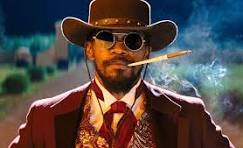
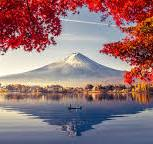

traitement choix des colonnes

In [107]:
# liste des colonnes['tconst', 'ordering', 'nconst', 'category', 'job', 'characters']
# Résumé des informations du dataframe
your_dataframe=title_principals2
print("#"+"-"*79)
print("valeurs uniques des colonnes:")
for col in your_dataframe.columns:
    print("#"+"#"*20)
    print(f"====colonne====: {col} \n====nb valeur uniques====:{your_dataframe[col].nunique()} ")
    if your_dataframe[col].nunique()< 15:
        print(r", ".join(f"'{item}'" for item in your_dataframe[col].unique().tolist()))
    else:
        unique_values = your_dataframe[col].unique()[:15]
        print("====15 premiers====: \n" + ", ".join(f"'{item}'" for item in unique_values))
print("#"+"-"*79)


#-------------------------------------------------------------------------------
valeurs uniques des colonnes:
#####################
====colonne====: tconst 
====nb valeur uniques====:9474833 
====15 premiers====: 
'tt0000001', 'tt0000002', 'tt0000003', 'tt0000004', 'tt0000005', 'tt0000006', 'tt0000007', 'tt0000008', 'tt0000009', 'tt0000010', 'tt0000011', 'tt0000012', 'tt0000013', 'tt0000014', 'tt0000015'
#####################
====colonne====: ordering 
====nb valeur uniques====:10 
'1', '2', '3', '4', '5', '6', '7', '8', '10', '9'
#####################
====colonne====: nconst 
====nb valeur uniques====:5232019 
====15 premiers====: 
'nm1588970', 'nm0005690', 'nm0374658', 'nm0721526', 'nm1335271', 'nm1770680', 'nm5442200', 'nm0443482', 'nm0653042', 'nm0249379', 'nm0179163', 'nm0183947', 'nm0653028', 'nm0063086', 'nm0183823'
#####################
====colonne====: category 
====nb valeur uniques====:12 
'self', 'director', 'cinematographer', 'composer', 'producer', 'editor', 'actor', 'ac

In [108]:
# on ne garde que les colonnes ['tconst', 'nconst', 'category']
col_to_keep = ['tconst', 'nconst', 'category']
title_principals2 = title_principals2[col_to_keep]

traitement de la colonne category

-**self** :  faire référence à un film ou à une émission de télévision où les acteurs jouent leur propre rôle.

-**director** : Le réalisateur est la personne qui supervise la production artistique et dramatique d’un film, et qui en dirige le tournage.

-**cinematographer** : Le directeur de la photographie est la personne qui est en charge de la prise de vue, de l’éclairage et de la composition visuelle du film.

-**composer** : Le compositeur crée la musique originale du film.

-**producer** : Le producteur supervise tous les aspects de la production d’un film, de la conception à la distribution.

-**editor** : L’éditeur assemble les images filmées pour créer le produit final.

-**actor** : Un acteur joue un personnage dans un film.

-**actress** : Une actrice joue un personnage dans un film.

-**writer** : Le scénariste écrit le scénario du film.

-**production_designer** : Le chef décorateur est responsable de la conception visuelle globale du film.

-**archive_footage** :  fait référence à un film qui utilise des images d’archives.

-**archive_sound** : fait référence à un film qui utilise des sons d’archives.

In [110]:
# liste des categories uniques 'self', 'director', 'cinematographer', 'composer', 'producer', 'editor', 'actor', 'actress', 'writer', 'production_designer', 'archive_footage', 'archive_sound'

# on ne garde que les ['self', 'director', 'producer', 'editor', 'actor', 'actress', 'writer']
title_principals2

,tconst,nconst,category
0,tt0000001,nm1588970,self
1,tt0000001,nm0005690,director
2,tt0000001,nm0374658,cinematographer
3,tt0000002,nm0721526,director
4,tt0000002,nm1335271,composer
...,...,...,...
59941345,tt9916880,nm0584014,director
59941346,tt9916880,nm0996406,director
59941347,tt9916880,nm1482639,writer
59941348,tt9916880,nm2586970,writer


In [111]:
types_category = title_principals2["category"].unique().tolist()

# surla liste des types ['imdbDisplay',
#  ['imdbDisplay','alternative', '\\N', 'tv', 'video', 'dvd', 'working', 'festival'] on ne garde que  ['imdbDisplay','tv', 'video','festival']
filtre_to_keep = ['self', 'director', 'producer','editor', 'actor', 'actress', 'writer']
filtre_type_category = title_principals2['category'].isin(filtre_to_keep)
title_principals2 = title_principals2[filtre_type_category]

In [112]:
title_principals2

,tconst,nconst,category
0,tt0000001,nm1588970,self
1,tt0000001,nm0005690,director
3,tt0000002,nm0721526,director
5,tt0000003,nm0721526,director
6,tt0000003,nm1770680,producer
...,...,...,...
59941345,tt9916880,nm0584014,director
59941346,tt9916880,nm0996406,director
59941347,tt9916880,nm1482639,writer
59941348,tt9916880,nm2586970,writer


In [ ]:
# title_akas_fr.drop(columns=["language", "ordering",
#                    "attributes", "isOriginalTitle"], inplace=True)

In [ ]:
# pour travailler sur du bigdata on peut prendre un échantillon des datasets
# df_sample =df.samples(n=20000, random_state=1)

#  autre possibilite en passant par un chunk
# n = 200000 # taille des chunks
# list_df = [df[i:i+n] for i in range(0, df.shape[0], n)]
# Dans les deux cas, list_df est une liste de DataFrames. Vous pouvez accéder à chaque chunk avec list_df[0], list_df[1], etc.
# Réassembler les chunks : Si vous voulez réassembler les chunks en un seul DataFrame, vous pouvez utiliser pd.concat
# df = pd.concat(list_df)

In [94]:
# sauvegarde des datafdrames sur le disque au format csv
# for nom, df in dfs.items():
#     df.to_csv(f"data_csv/{nom}.csv", index=False)

In [5]:
# liste des datafdrames
for df in dfs:
    print(f"{df} ")

name_basics 
title_akas 
title_basics 
title_crew 
title_episode 
title_principals 
title_ratings 


In [7]:
# Résumé des informations des dataframes
for df in dfs:
    print(f"\ndf :{df} ")
    your_dataframe = dfs[df]
    print(f"shape: {your_dataframe.shape} - list columns :{your_dataframe.columns.tolist()} \nliste des colonnes numeriques: {your_dataframe.select_dtypes(include=[np.number]).columns.tolist(
    )} \nliste des colonnes non numeriques: {your_dataframe.select_dtypes(exclude=[np.number]).columns.tolist()} \nColonne avec des na :\n{your_dataframe.isna().sum()}")
    # print(f"Noms des colonnes avec au moins une valeur NA : {your_dataframe.columns[your_dataframe.isna().any()].tolist()}")
    # print(f"Nombre de lignes avec au moins une valeur NA : {your_dataframe.isna().any(axis=1).sum()}")
    # print(f"head : \n{your_dataframe.head(2)}")


df :name_basics 
shape: (13149959, 6) - list columns :['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles'] 
liste des colonnes numeriques: [] 
liste des colonnes non numeriques: ['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles'] 
Colonne avec des na :
nconst                     0
primaryName                7
birthYear                  0
deathYear                  0
primaryProfession    2631479
knownForTitles             0
dtype: int64

df :title_akas 
shape: (38367336, 8) - list columns :['titleId', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'isOriginalTitle'] 
liste des colonnes numeriques: ['ordering'] 
liste des colonnes non numeriques: ['titleId', 'title', 'region', 'language', 'types', 'attributes', 'isOriginalTitle'] 
Colonne avec des na :
titleId              0
ordering             0
title               18
region             117
language             0
types                0
attr

In [8]:
for df in dfs:
    print(f"\ndf :{df} ")
    your_dataframe = dfs[df]
    print(f"shape: {your_dataframe.shape}\nlist columns :{your_dataframe.columns.tolist()} \nliste des colonnes numeriques: {your_dataframe.select_dtypes(include=[
          np.number]).columns.tolist()} \nliste des colonnes non numeriques: {your_dataframe.select_dtypes(exclude=[np.number]).columns.tolist()}")


df :name_basics 
shape: (13149959, 6)
list columns :['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles'] 
liste des colonnes numeriques: [] 
liste des colonnes non numeriques: ['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles']

df :title_akas 
shape: (38367336, 8)
list columns :['titleId', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'isOriginalTitle'] 
liste des colonnes numeriques: ['ordering'] 
liste des colonnes non numeriques: ['titleId', 'title', 'region', 'language', 'types', 'attributes', 'isOriginalTitle']

df :title_basics 
shape: (10455620, 9)
list columns :['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres'] 
liste des colonnes numeriques: [] 
liste des colonnes non numeriques: ['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres']

df :title_cre

### Preprocessing dataframes

In [54]:
# # création d'un fichier de synthése des dataframes au format markdown
# import datetime

# # date et heure actuelles
# now = datetime.datetime.now()
# # Formatage date et heure au format 2024-01-01-9h30
# date_time = now.strftime("%Y-%m-%d-%Hh%M")
# # Ajouter la date et l'heure au nom du fichier
# filename = f"synthése_dataframes_{date_time}.md"
# with open(filename, "w", encoding="utf-8") as f:
#     for df in dfs:
#         your_dataframe = dfs[df]
#         f.write(f"\n## DataFrame : {df}\n")
#         f.write(f"- **Shape** : `{your_dataframe.shape}`\n")
#         f.write(
#             f"- **Liste des colonnes** : `{your_dataframe.columns.tolist()}`\n")
#         f.write(
#             f"- **Liste des colonnes numériques** : `{
#                 your_dataframe.select_dtypes(include=[np.number]).columns.tolist()}`\n"
#         )
#         f.write(
#             f"- **Liste des colonnes non numériques** : `{
#                 your_dataframe.select_dtypes(exclude=[np.number]).columns.tolist()}`\n"
#         )
#         f.write(
#             f"- **Colonnes avec des NA** :\n```\n{
#                 your_dataframe.isna().sum()}\n```\n"
#         )
#         f.write(
#             f"- **Noms des colonnes avec au moins une valeur NA** : `{
#                 your_dataframe.columns[your_dataframe.isna().any()].tolist()}`\n"
#         )
#         f.write(
#             f"- **Nombre de lignes avec au moins une valeur NA** : `{
#                 your_dataframe.isna().any(axis=1).sum()}`\n"
#         )
#         headers = " | ".join(your_dataframe.columns.tolist())
#         # Obtenir les lignes
#         rows = [" | ".join(row)
#                 for row in your_dataframe.head(2).astype(str).values]
#         # Écrire les en-têtes et les lignes dans le fichier
#         f.write(f"- **head** :\n```\n{headers}\n{'\n'.join(rows)}\n```\n")

### Suite Analyse du fichier de synthése, choix des colonnes
les colonnes les plus interessantes pour faire des recommendations de films sont:

Ratings : averageRating dans title_ratings pour recommander les films les mieux notés.

Popularité : numVotes dans title_ratings 

Métadonnées du film : genres, startYear, etc. pour recommander des films similaires à ceux que l’utilisateur a aimés par le passé.

Collaborations : title_crew et name_basics, pour recommander des films basés sur les réalisateurs, les scénaristes ou les acteurs 

### Nous allons garder les colonnes suivantes:

1. **name_basics** : 
    - `nconst` : 
    - `primaryName` : Le nom de la personne peut être utile pour identifier les acteurs, réalisateurs, etc. que l'utilisateur aime.
    - `primaryProfession` : La profession principale peut aider à identifier si la personne est un acteur, un réalisateur, etc.
    - `knownForTitles` : Les titres pour lesquels la personne est connue peuvent aider à identifier les films populaires.

2. **title_akas** :
    - `titleId` 
    - `title` 
    - `region` 
3. **title_basics** :
    - `tconst` : Identifiant unique du film, utile pour relier les différents datasets.
    - `primaryTitle` et `originalTitle` 
    - `startYear` 
    - `genres` 
4. **title_crew** :
    - `tconst` : Identifiant unique du film, utile pour relier les différents datasets.
    - `directors` et `writers` : Les réalisateurs et les scénaristes 
5. **title_principals** :
    - `tconst` : Identifiant unique du film, utile pour relier les différents datasets.
    - `nconst` : Identifiant unique de la personne, utile pour relier les personnes aux films.
    - `category` : La catégorie (par exemple, acteur, réalisateur)
6. **title_ratings** :
    - `tconst` : Identifiant unique du film, utile pour relier les différents datasets.
    - `averageRating` et `numVotes` : La note moyenne et le nombre de votes 


In [6]:
# Création d'un nouveau dataframe Liste des colonnes à conserver
import pandas as pd

cols_to_keep = {
    "name_basics": ["nconst", "primaryName", "primaryProfession", "knownForTitles"],
    "title_akas": ["titleId", "title", "region"],
    "title_basics": ["tconst", "primaryTitle", "originalTitle", "startYear", "genres"],
    "title_crew": ["tconst", "directors", "writers"],
    "title_episode": ["tconst", "episodeNumber", "seasonNumber"],
    "title_principals": ["tconst", "nconst", "category"],
    "title_ratings": ["tconst", "averageRating", "numVotes"],
}


# Création du nouveau dataset
# Création du nouveau dataset
dfsd_light = {}
for k, v in cols_to_keep.items():
    print(f"{k} ")
    print(f":{v}")
    dfsd_light[k] = dfs[k][v]

name_basics 
:['nconst', 'primaryName', 'primaryProfession', 'knownForTitles']
title_akas 
:['titleId', 'title', 'region']
title_basics 
:['tconst', 'primaryTitle', 'originalTitle', 'startYear', 'genres']
title_crew 
:['tconst', 'directors', 'writers']
title_episode 
:['tconst', 'episodeNumber', 'seasonNumber']
title_principals 
:['tconst', 'nconst', 'category']
title_ratings 
:['tconst', 'averageRating', 'numVotes']


In [ ]:
# dfs_light_df = pd.DataFrame(dfs_light_df)

In [71]:
# controle des noms de colonnes
for df in dfsd_light:
    print(f"\ndf :{df} ")
    your_dataframe = dfs[df]
    print(f"shape: {your_dataframe.shape}\nlist columns :{your_dataframe.columns.tolist()} \nliste des colonnes numeriques: {your_dataframe.select_dtypes(include=[
          np.number]).columns.tolist()} \nliste des colonnes non numeriques: {your_dataframe.select_dtypes(exclude=[np.number]).columns.tolist()}")


df :name_basics 
shape: (13149959, 6)
list columns :['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles'] 
liste des colonnes numeriques: [] 
liste des colonnes non numeriques: ['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles']

df :title_akas 
shape: (38367336, 8)
list columns :['titleId', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'isOriginalTitle'] 
liste des colonnes numeriques: ['ordering'] 
liste des colonnes non numeriques: ['titleId', 'title', 'region', 'language', 'types', 'attributes', 'isOriginalTitle']

df :title_basics 
shape: (10455620, 9)
list columns :['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres'] 
liste des colonnes numeriques: [] 
liste des colonnes non numeriques: ['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres']

df :title_cre

In [7]:
# Créez une copie explicite de votre DataFrame
df_sauve = dfsd_light["name_basics"].copy()
df = df_sauve.copy()

In [8]:
# Séparez les titres dans 'knownForTitles'
df["knownForTitles"] = df["knownForTitles"].str.split(",")

In [9]:
# Exploser la colonne 'knownForTitles' et la renommer en 'tconst'
df = df.explode("knownForTitles").rename(columns={"knownForTitles": "tconst"})

In [10]:
# Remplacer les '\n' par des valeurs vides
df["tconst"] = df["tconst"].str.replace("\\N", "")

In [11]:
dfsd_light["name_basics"] = df
dfsd_light["name_basics"]["tconst"] = dfsd_light["name_basics"]["tconst"].str.replace(
    "\\N", ""
)

In [12]:
dfsd_light["name_basics"]
# Résumé des informations du dataframe
your_dataframe = dfsd_light["name_basics"]
print(f"\nshape: {your_dataframe.shape} \nlist columns :\n{
      your_dataframe.columns.tolist()} ")
print(f"liste des colonnes numeriques: \n{
      your_dataframe.select_dtypes(include=[np.number]).columns.tolist()}\n")
print(f"liste des colonnes non numeriques: \n{
      your_dataframe.select_dtypes(exclude=[np.number]).columns.tolist()} ")
print(f"Noms des colonnes avec au moins une valeur NA : {
      your_dataframe.columns[your_dataframe.isna().any()].tolist()}")
print(f"Nombre de lignes avec au moins une valeur NA : {
      your_dataframe.isna().any(axis=1).sum()}")
print(f"Colonne avec des na :{your_dataframe.isna().sum()} \n")
print(f"\ndf head :\n{your_dataframe.head(2)} \n")
print(f"\ndf describe :\n{your_dataframe.describe()} \n")


shape: (23010421, 4) 
list columns :
['nconst', 'primaryName', 'primaryProfession', 'tconst'] 
liste des colonnes numeriques: 
[]

liste des colonnes non numeriques: 
['nconst', 'primaryName', 'primaryProfession', 'tconst'] 
Noms des colonnes avec au moins une valeur NA : ['primaryName', 'primaryProfession']
Nombre de lignes avec au moins une valeur NA : 3061205
Colonne avec des na :nconst                     0
primaryName               10
primaryProfession    3061196
tconst                     0
dtype: int64 


df head :
      nconst   primaryName               primaryProfession     tconst
0  nm0000001  Fred Astaire  soundtrack,actor,miscellaneous  tt0050419
0  nm0000001  Fred Astaire  soundtrack,actor,miscellaneous  tt0072308 


df describe :
           nconst  primaryName primaryProfession    tconst
count    23010421     23010411          19949225  23010421
unique   13153024     10154062             21649   1949805
top     nm5907173  David Smith             actor          
freq    

In [ ]:
# Merge de name_basics et title_akas
df1 = dfsd_light["name_basics"]
df2 = dfsd_light["title_akas"]

# Merge des dataframes :
df_nconst = df1.merge(df2, how="inner", left_on="tconst", right_on="titleId")

In [62]:
df = df_nconst
print(f"\ncolonnes :\n{df.columns.tolist()} \n")
# Conversion avec des espaces tous les milliers
shape = df.shape
shape_format = tuple("{:,}".format(x).replace(",", " ") for x in shape)
print("Shape avec des espaces tous les milliers :", shape_format)


colonnes :
['nconst', 'primaryName', 'primaryProfession', 'knownForTitles', 'titleId', 'title', 'region'] 

Shape avec des espaces tous les milliers : ('51 517 295', '7')


In [42]:
# merge des df ayant la colonne tconst en commun
df3 = dfsd_light["title_basics"]
df4 = dfsd_light["title_crew"]
df5 = dfsd_light["title_principals"]
df6 = dfsd_light["title_ratings"]
df7 = dfsd_light["title_episode"]
# Merge des dataframes :
df_tconst = df3.merge(df4, how="outer", on="tconst")
df_tconst = df_tconst.merge(df5, how="inner", on="tconst")
df_tconst = df_tconst.merge(df6, how="inner", on="tconst")
df_tconst = df_tconst.merge(df7, how="inner", on="tconst")

In [58]:
df = df_tconst
print(f"\ncolonnes :\n{df.columns.tolist()} \n")
# Conversion avec des espaces tous les milliers
shape = df.shape
shape_format = tuple("{:,}".format(x).replace(",", " ") for x in shape)
print("Shape avec des espaces tous les milliers :", shape_format)


colonnes :
['tconst', 'primaryTitle', 'originalTitle', 'startYear', 'genres', 'directors', 'writers', 'nconst', 'category', 'averageRating', 'numVotes', 'episodeNumber', 'seasonNumber'] 

Shape avec des espaces tous les milliers : ('60 909 999', '13')


In [ ]:
# merge des 2 df df_nconst et df_tconst
df_nconst = df1.merge(df2, how="outer", left_on="nconst", right_on="titleId")

In [ ]:
# Fusionner tous les dataframes en un seul
dfsd_light_df = pd.concat(dfsd_light.values(), ignore_index=True)

# Afficher les premières lignes du dataframe
print(dfsd_light_df.head())

In [14]:
dfsd_light

{'name_basics':              nconst         primaryName                    primaryProfession  \
 0         nm0000001        Fred Astaire       soundtrack,actor,miscellaneous   
 1         nm0000002       Lauren Bacall                   actress,soundtrack   
 2         nm0000003     Brigitte Bardot  actress,soundtrack,music_department   
 3         nm0000004        John Belushi              actor,soundtrack,writer   
 4         nm0000005      Ingmar Bergman                writer,director,actor   
 ...             ...                 ...                                  ...   
 13149954  nm9993714   Romeo del Rosario  animation_department,art_department   
 13149955  nm9993716       Essias Loberg                                  NaN   
 13149956  nm9993717  Harikrishnan Rajan                      cinematographer   
 13149957  nm9993718         Aayush Nair                      cinematographer   
 13149958  nm9993719          Andre Hill                                  NaN   
 
           

In [ ]:
# suppression des colonnes
dfs["title_basics"].drop(
    ["colonne_a_supprimer1", "colonne_a_supprimer2"], axis=1, inplace=True
)

In [ ]:
# df=dfs["name_basics"].copy()
# df.explode("knownForTitles")

In [ ]:
# Test indépendance entre deux variables quantitatives / Test de corrélation Pearson
# Test d'indépendance entre deux variables qualitatives / Test du Chi²
# Test d'indépendance entre une variable qualitative et une quantitative / Test de Fisher avec l'analyse de la variance (ANOVA)

prétraitement de vos DataFrames :

1. **name_basics** : Vous pouvez convertir les colonnes `birthYear` et `deathYear` en type numérique. De plus, la colonne `primaryProfession` semble contenir plusieurs professions pour une même personne, vous pourriez diviser cette colonne en plusieurs colonnes binaires (une pour chaque profession).

2. **title_akas** : La colonne `isOriginalTitle` pourrait être convertie en booléen. De plus, si vous n'avez pas besoin de toutes les régions ou langues, vous pourriez filtrer ces colonnes pour ne garder que les lignes pertinentes.

3. **title_basics** : Les colonnes `startYear` et `endYear` pourraient être converties en type numérique. La colonne `genres` semble contenir plusieurs genres pour un même titre, vous pourriez diviser cette colonne en plusieurs colonnes binaires (une pour chaque genre).

4. **title_crew** : Les colonnes `directors` et `writers` semblent contenir plusieurs personnes pour un même titre, vous pourriez diviser ces colonnes en plusieurs colonnes (une pour chaque personne).

5. **title_episode** : Les colonnes `seasonNumber` et `episodeNumber` pourraient être converties en type numérique.

6. **title_principals** : La colonne `characters` semble contenir plusieurs personnages pour une même personne, vous pourriez diviser cette colonne en plusieurs colonnes (une pour chaque personnage).

7. **title_ratings** : Les colonnes `averageRating` et `numVotes` pourraient être converties en type numérique.

 gérer les valeurs manquantes, de supprimer les doublons, effectuer une normalisation ou une standardisation des données si nécessaire. 
 fusionner des DataFrames en utilisant les colonnes appropriées comme clés. 


 KPI des DataFrames, possibilités :

1. **name_basics** : Nombre total d'acteurs, nombre d'acteurs par profession, nombre d'acteurs nés chaque année, etc.
2. **title_akas** : Nombre total de titres, nombre de titres par région ou par langue, etc.
3. **title_basics** : Nombre total de titres par type (film, série, etc.), durée moyenne des titres, nombre de titres par genre, etc.
4. **title_crew** : Nombre de réalisateurs et scénaristes uniques, nombre moyen de réalisateurs et scénaristes par titre, etc.
5. **title_episode** : Nombre total d'épisodes, nombre moyen d'épisodes par saison, etc.
6. **title_principals** : Nombre moyen de personnages par titre, nombre de titres par acteur, etc.
7. **title_ratings** : Note moyenne des titres, nombre moyen de votes par titre, etc.

Pour proposer 10 suggestions de films en fonction du choix d'un film d'un utilisateur, vous pouvez utiliser une approche de filtrage collaboratif ou basée sur le contenu. Voici une approche simple basée sur le contenu :

1. **Sélectionnez le film choisi par l'utilisateur** dans votre DataFrame `title_basics`.
2. **Identifiez les genres** de ce film.
3. **Filtrez** votre DataFrame `title_basics` pour ne garder que les films qui partagent au moins un genre avec le film choisi par l'utilisateur.
4. **Classez** ces films en fonction de leur note moyenne dans votre DataFrame `title_ratings` (vous pouvez également prendre en compte le nombre de votes pour éviter les films avec une note moyenne élevée mais un faible nombre de votes).
5. **Sélectionnez les 10 premiers films** de cette liste.


In [95]:
dfs2 = dfs.copy()
dfs3 = dfs.copy()
dfs4 = dfs.copy()
print(f"\ndfs2['title_basics'].shape :\n{dfs2['title_basics'].shape} \n")


dfs2['title_basics'].shape :
(10450471, 9) 



In [ ]:
# suppression des na des colonnes concernées
dfs2["title_basics"].dropna(
    subset=["primaryTitle", "originalTitle", "genres"], inplace=True
)
print(f"\ndfs2['title_basics'].shape :\n{dfs2['title_basics'].shape} \n")

In [ ]:
# clustering
from sklearn.cluster import KMeans

# Sélectionnez les colonnes pour le clustering
# Remplacez par vos colonnes
data = dfs2["title_basics"][["startYear", "endYear"]]

# Créez l'objet KMeans
# Remplacez 3 par le nombre de clusters que vous voulez
kmeans = KMeans(n_clusters=3)

# Ajustez le modèle aux données
kmeans.fit(data)

# Obtenez les labels de cluster pour chaque observation
labels = kmeans.labels_

In [ ]:
# for df in dfs2:
#     # supprime les valeurs manquantes sur les colonnes
#     # dfs2[df].dropna(axis=0, inplace=True)
#     # supprime les valeurs manquantes sur les lignes
#     dfs2[df].dropna(axis=1, inplace=True)
#     print(f"\nshape {df}:\n{dfs2[df].shape} \n")

In [76]:
# suppression des na des colonnes concernées
dfs2["title_basics"].dropna(
    subset=["primaryTitle", "originalTitle", "genres"], inplace=True
)


def regrouper_genres(genre):
    if genre in ["Action", "Adventure", "Thriller", "War"]:
        return "Action et Aventure"
    elif genre in ["Comedy", "Romance", "Family"]:
        return "Comédies"
    elif genre in ["Drama", "Crime", "Mystery"]:
        return "Drames"
    elif genre in ["Horror", "Sci-Fi"]:
        return "Science-Fiction et Fantastique"
    elif genre in ["Biography", "History", "Documentary"]:
        return "Documentaires"
    elif genre in ["Music", "Musical"]:
        return "Musique et Comédies Musicales"
    else:
        return "Autres"


# Appliquer la fonction de regroupement aux genres
dfs2["title_basics"]["genres"] = dfs2["title_basics"]["genres"].apply(
    regrouper_genres)

# Utiliser get_dummies sur la colonne de genres regroupés
dfs2["title_basics"] = dfs2["title_basics"].join(
    dfs2["title_basics"]["genres"].str.get_dummies(",")
)

In [77]:
# Résumé des informations du dataframe
your_dataframe = dfs2["title_basics"]
print(
    f"\nshape: {your_dataframe.shape} \nlist columns :\n{
        your_dataframe.columns.tolist()} "
)
print(
    f"liste des colonnes numeriques: \n{
        your_dataframe.select_dtypes(include=[np.number]).columns.tolist()}\n"
)
print(
    f"liste des colonnes non numeriques: \n{
        your_dataframe.select_dtypes(exclude=[np.number]).columns.tolist()} "
)
print(
    f"Noms des colonnes avec au moins une valeur NA : {
        your_dataframe.columns[your_dataframe.isna().any()].tolist()}"
)
print(
    f"Nombre de lignes avec au moins une valeur NA : {
        your_dataframe.isna().any(axis=1).sum()}"
)
print(f"Colonne avec des na :{your_dataframe.isna().sum()} \n")
print(f"\ndf head :\n{your_dataframe.head(10)} \n")
print(f"\ndf describe :\n{your_dataframe.describe()} \n")


shape: (10450471, 16) 
list columns :
['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres', 'Action et Aventure', 'Autres', 'Comédies', 'Documentaires', 'Drames', 'Musique et Comédies Musicales', 'Science-Fiction et Fantastique'] 
liste des colonnes numeriques: 
['startYear', 'endYear', 'Action et Aventure', 'Autres', 'Comédies', 'Documentaires', 'Drames', 'Musique et Comédies Musicales', 'Science-Fiction et Fantastique']

liste des colonnes non numeriques: 
['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'runtimeMinutes', 'genres'] 
Noms des colonnes avec au moins une valeur NA : ['primaryTitle', 'originalTitle', 'startYear', 'endYear']
Nombre de lignes avec au moins une valeur NA : 10333737
Colonne avec des na :tconst                                   0
titleType                                0
primaryTitle                            17
originalTitle                           17
isAdult           

In [79]:
nombre_de_films_pour_adultes = dfs2["title_basics"][
    dfs2["title_basics"]["isAdult"] == "1"
].shape[0]
print("Nombre de films pour adultes : ", nombre_de_films_pour_adultes)

Nombre de films pour adultes :  331925


In [ ]:
# Prétraitement pour title_crew
dfs2["title_crew"] = dfs2["title_crew"].join(
    dfs2["title_crew"]["directors"].str.get_dummies(
        ",").add_prefix("director_")
)
dfs2["title_crew"] = dfs2["title_crew"].join(
    dfs2["title_crew"]["writers"].str.get_dummies(",").add_prefix("writer_")
)

In [ ]:
# Prétraitement pour title_episode
dfs2["title_episode"]["seasonNumber"] = pd.to_numeric(
    dfs2["title_episode"]["seasonNumber"], errors="coerce"
)
dfs2["title_episode"]["episodeNumber"] = pd.to_numeric(
    dfs2["title_episode"]["episodeNumber"], errors="coerce"
)

In [ ]:
# Prétraitement pour title_principals
dfs2["title_principals"] = dfs2["title_principals"].join(
    dfs2["title_principals"]["characters"].str.get_dummies(
        ",").add_prefix("character_")
)

In [ ]:
# Prétraitement pour title_ratings
dfs2["title_ratings"]["averageRating"] = pd.to_numeric(
    dfs2["title_ratings"]["averageRating"], errors="coerce"
)
dfs2["title_ratings"]["numVotes"] = pd.to_numeric(
    dfs2["title_ratings"]["numVotes"], errors="coerce"
)

In [ ]:
# Fusion des tables
df_titles = dfs2["title_basics"].merge(
    dfs2["title_crew"], on="tconst", how="left")
df_titles = df_titles.merge(dfs2["title_episode"], on="tconst", how="left")
df_titles = df_titles.merge(dfs2["title_principals"], on="tconst", how="left")
df_titles = df_titles.merge(dfs2["title_ratings"], on="tconst", how="left")

print(df.head())

In [ ]:
# KPI pour name_basics
print("Nombre total d'acteurs : ", dfs2["name_basics"]["nconst"].nunique())
print(
    "Nombre d'acteurs par profession : ",
    dfs2["name_basics"]["primaryProfession"].value_counts(),
)

# KPI pour title_basics
print(
    "Nombre total de titres par type : ",
    dfs2["title_basics"]["titleType"].value_counts(),
)
print("Durée moyenne des titres : ",
      dfs2["title_basics"]["runtimeMinutes"].mean())

# KPI pour title_ratings
print("Note moyenne des titres : ",
      dfs2["title_ratings"]["averageRating"].mean())
print("Nombre moyen de votes par titre : ",
      dfs2["title_ratings"]["numVotes"].mean())


# Suggestions de films
def suggest_movies(movie_title):
    # Sélectionnez le film choisi par l'utilisateur
    movie = dfs2["title_basics"][
        dfs2["title_basics"]["primaryTitle"] == movie_title
    ].iloc[0]

    # Identifiez les genres de ce film
    genres = movie["genres"].split(",")

    # Filtrez votre DataFrame pour ne garder que les films qui partagent au moins un genre avec le film choisi
    similar_movies = dfs2["title_basics"][
        dfs2["title_basics"]["genres"].apply(
            lambda x: any(genre in x for genre in genres)
        )
    ]

    # Fusionnez avec title_ratings
    similar_movies = similar_movies.merge(dfs2["title_ratings"], on="tconst")

    # Classez ces films en fonction de leur note moyenne
    similar_movies = similar_movies.sort_values(
        by="averageRating", ascending=False)

    # Sélectionnez les 10 premiers films de cette liste
    top_10_movies = similar_movies.head(10)

    return top_10_movies


# Remplacez par le titre du film choisi par l'utilisateur
movie_title = "Carmencita"
print("Voici 10 suggestions de films basées sur le film ", movie_title, " :")
print(suggest_movies(movie_title))